Visualizing Images

                                          filename  width  height class  xmin   
0   U7_jpg.rf.0037faea78f8a89329a93006132921b3.jpg    390     390     U    38  \
1  P12_jpg.rf.0046c1c30abbbccd31716c5b2ad835b9.jpg    372     372     P    84   
2   K4_jpg.rf.00821732715c9137b8060360770ea1d8.jpg    372     372     K    42   
3   W6_jpg.rf.00d19bc3a49f6469e2afa3aa92f14ff4.jpg    412     412     W    22   
4  J30_jpg.rf.00d20e595026b31773ded47509545471.jpg    382     382     J   122   

   ymin  xmax  ymax  
0    69   347   389  
1   203   330   332  
2    12   351   369  
3    73   377   412  
4   204   250   334  


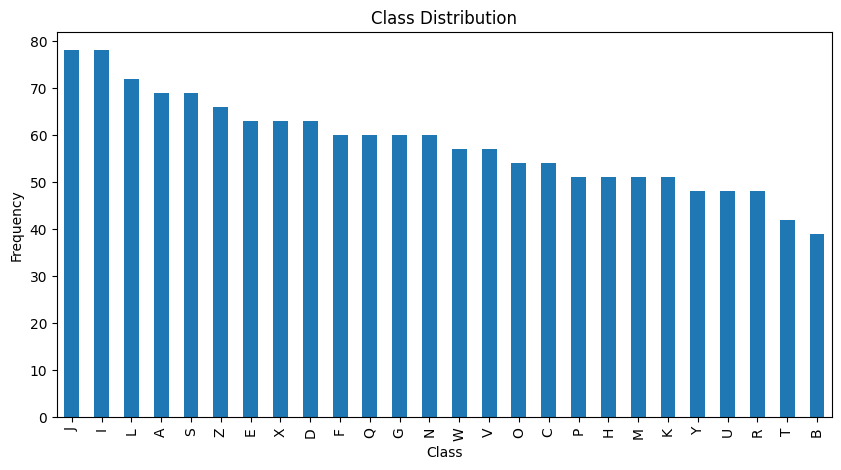

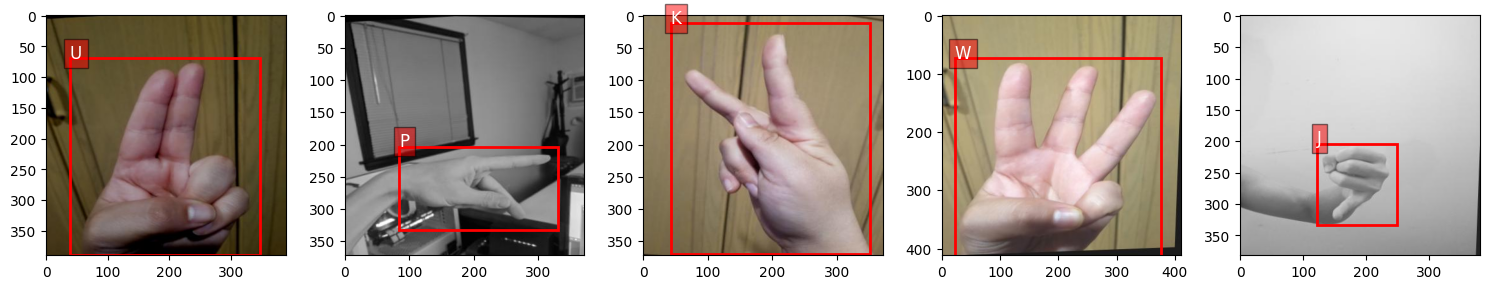

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from matplotlib.patches import Rectangle

# Load the CSV file
csv_file_path = 'dataset/train/_annotations.csv'
data = pd.read_csv(csv_file_path)

# Display the first few rows of the dataset
print(data.head())

# Visualize class distribution
class_counts = data['class'].value_counts()
plt.figure(figsize=(10, 5))
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

# Define a function to visualize images with bounding boxes
def visualize_image(ax, image_file, data):
    img_path = os.path.join('dataset/train', image_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    
    image_data = data[data['filename'] == image_file]
    for _, row in image_data.iterrows():
        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        width, height = xmax - xmin, ymax - ymin
        rect = Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, row['class'], fontsize=12, color='w', bbox=dict(facecolor='r', alpha=0.5))

# Visualize a few images with bounding boxes
sample_images = data['filename'].unique()[:5]

fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 3))
for ax, image_file in zip(axes, sample_images):
    visualize_image(ax, image_file, data)
plt.tight_layout()
plt.show()



## Data Preprocessing for the Model

In [82]:
# Create a dictionary that maps letters to numbers
letter_to_number = {letter: index for index, letter in enumerate("ABCDEFGHIJKLMNOPQRSTUVWXYZ", start=0)}

# Create a reverse dictionary that maps numbers to letters
number_to_letter = {index: letter for index, letter in enumerate("ABCDEFGHIJKLMNOPQRSTUVWXYZ", start=0)}

# Create a category index dictionary that maps class IDs to their category information
category_index = {class_id: {'id': class_id, 'name': letter} for class_id, letter in number_to_letter.items()}

print("letter_to_number:", letter_to_number)
print("number_to_letter:", number_to_letter)
print("category_index:", category_index)


letter_to_number: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}
number_to_letter: {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}
category_index: {0: {'id': 0, 'name': 'A'}, 1: {'id': 1, 'name': 'B'}, 2: {'id': 2, 'name': 'C'}, 3: {'id': 3, 'name': 'D'}, 4: {'id': 4, 'name': 'E'}, 5: {'id': 5, 'name': 'F'}, 6: {'id': 6, 'name': 'G'}, 7: {'id': 7, 'name': 'H'}, 8: {'id': 8, 'name': 'I'}, 9: {'id': 9, 'name': 'J'}, 10: {'id': 10, 'name': 'K'}, 11: {'id': 11, 'name': 'L'}, 12: {'id': 12, 'name': 'M'}, 13: {'id': 13, 'name': 'N'}, 14: {'id': 14, 'name': 'O'}, 15: {'id': 15, 'name': 'P'}, 16: {'id': 16, 'name': 'Q'}, 17: {'id': 17, 'name': '

## Tensorflow Object Detection API


In [83]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models
     

# Install the Object Detection API in linux bash
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [84]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import config_util
from object_detection.builders import model_builder

%matplotlib inline

## Dataset Preparation

In [85]:
from PIL import ImageOps
def load_image_into_numpy_array(path, target_size=(224, 224)):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  # Check the Pillow version and use the appropriate resampling method
  if hasattr(Image, "Resampling"):
      resampling_method = Image.Resampling.LANCZOS
  else:
      resampling_method = Image.LANCZOS
  image = ImageOps.fit(image, target_size, resampling_method)
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

In [86]:
# Load your dataset from a CSV file
data = pd.read_csv('dataset/train/_annotations.csv')

# Load images and store them in a list
train_image_dir = 'dataset/train'
train_images_np = []
image_filenames = data['filename'].unique()

for image_filename in image_filenames:
    image_path = os.path.join(train_image_dir, image_filename)
    train_images_np.append(load_image_into_numpy_array(image_path))


In [94]:
train_images_np = []
original_image_dims = []

for image_filename in image_filenames:
    image_path = os.path.join(train_image_dir, image_filename)
    image_np = load_image_into_numpy_array(image_path)
    train_images_np.append(image_np)

    img_data = data.loc[data['filename'] == image_filename]
    original_image_dims.append((img_data['width'].iloc[0], img_data['height'].iloc[0]))

gt_boxes = []

for idx, image_filename in enumerate(image_filenames):
    boxes = data.loc[data['filename'] == image_filename, ['ymin', 'xmin', 'ymax', 'xmax']].values
    orig_width, orig_height = original_image_dims[idx]
    new_width, new_height = 224, 224

    # Normalize the ground truth box coordinates based on the new dimensions
    boxes_normalized = boxes / np.array([orig_height, orig_width, orig_height, orig_width])
    gt_boxes.append(boxes_normalized.astype(np.float32))


In [95]:
num_classes = 26


In [96]:
# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

Done prepping data.


## Visualizing as sanity check

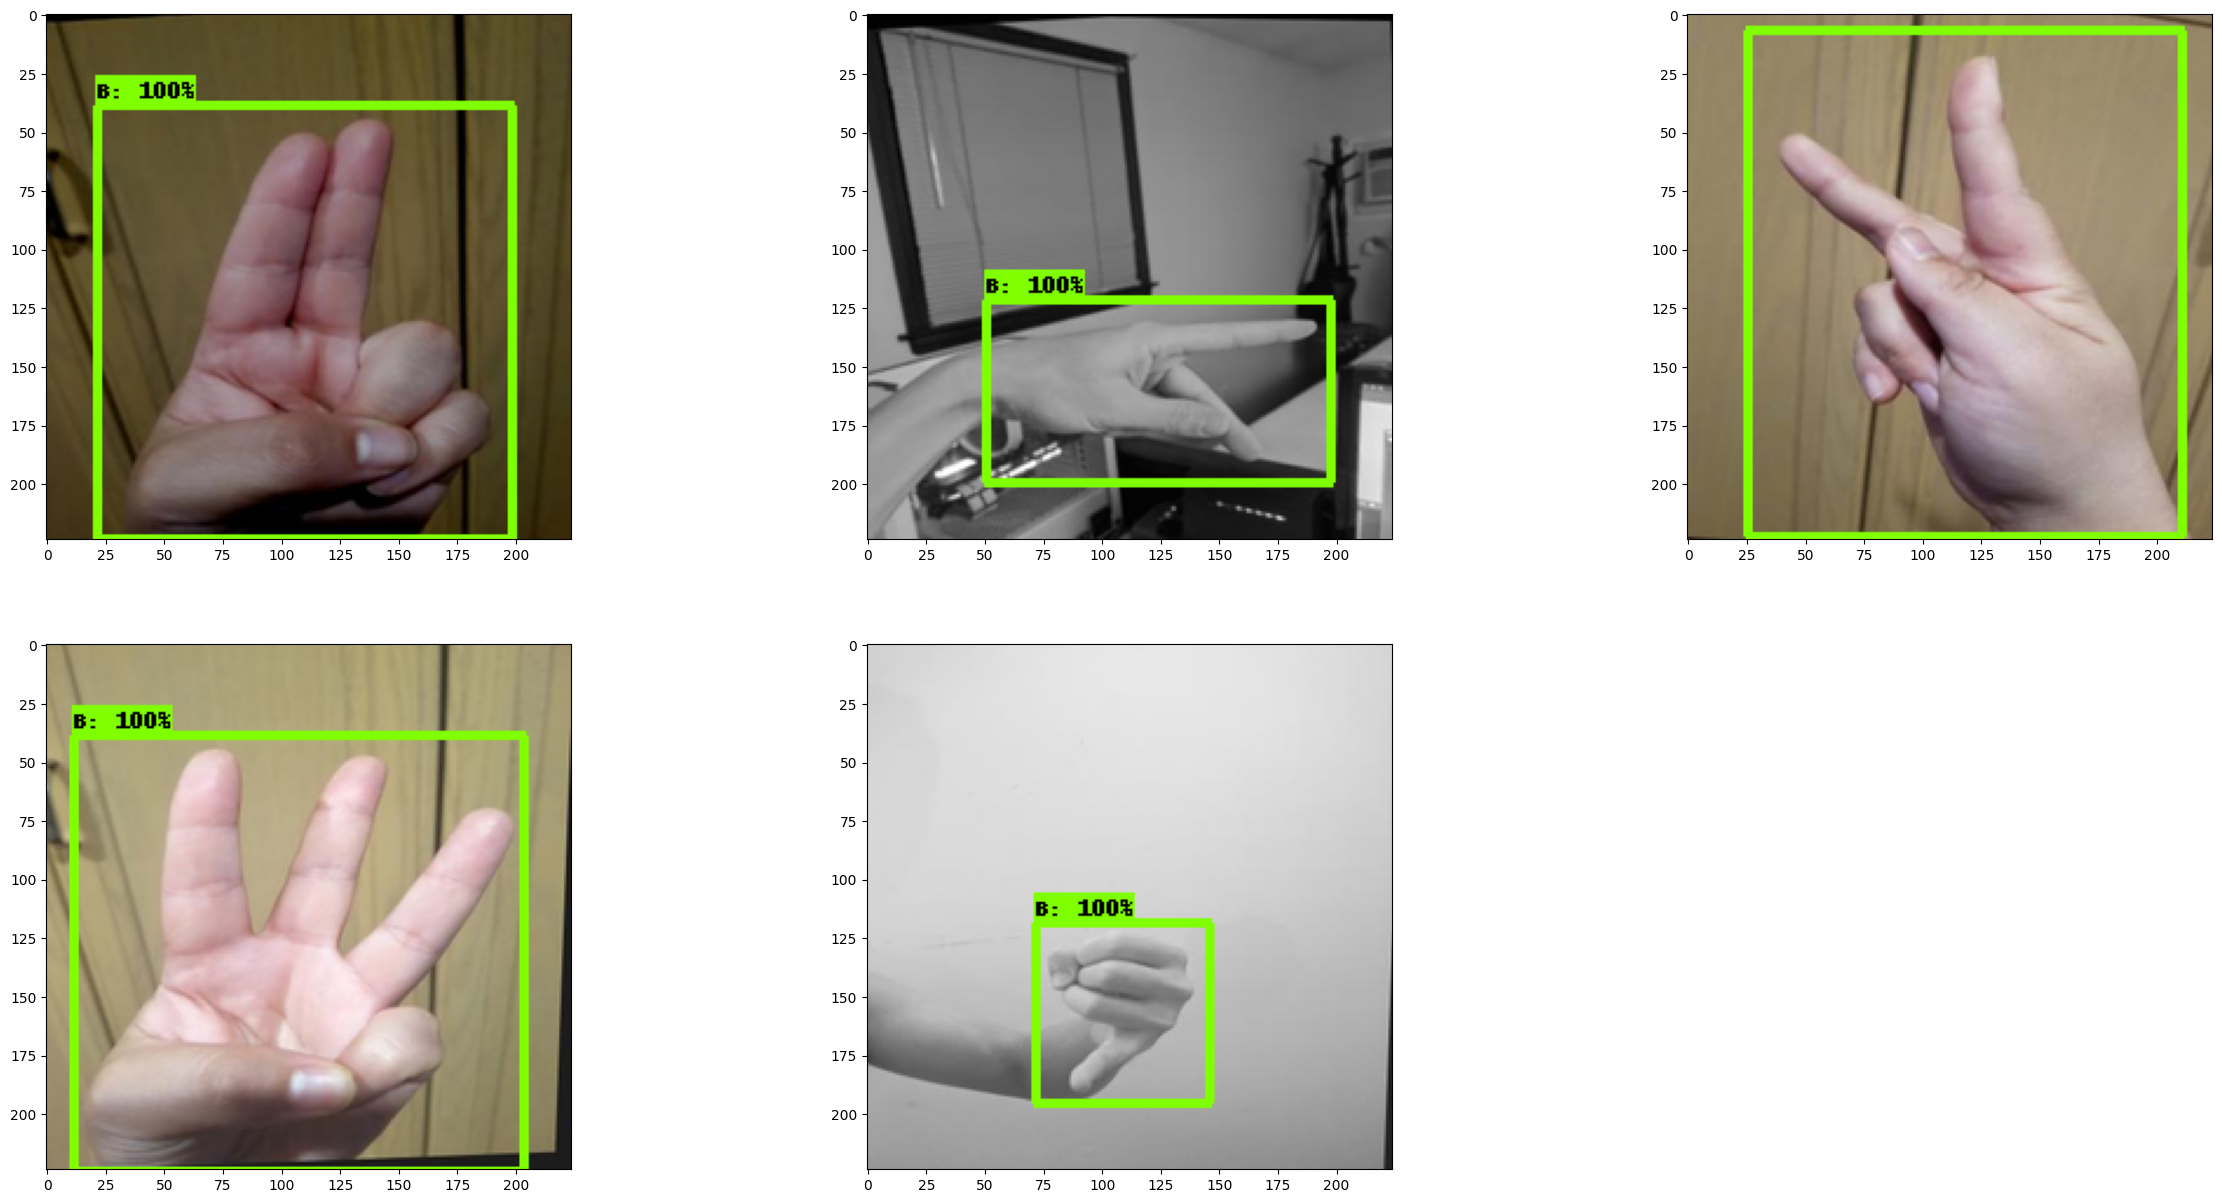

In [97]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(5):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
plt.show()

## Loading the model

In [98]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!tar -xf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!if [ -d "models/research/object_detection/test_data/checkpoint" ]; then rm -Rf models/research/object_detection/test_data/checkpoint; fi
!mkdir models/research/object_detection/test_data/checkpoint
!mv ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2023-04-29 13:27:14--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.68.80, 2607:f8b0:4007:811::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.68.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz.3’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M  8.63MB/s    in 2.3s    

2023-04-29 13:27:17 (8.63 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz.3’ saved [20515344/20515344]



In [99]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 26
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# This will be where we save checkpoint & config for TFLite conversion later.
output_directory = 'output/'
output_checkpoint_dir = os.path.join(output_directory, 'checkpoint')

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)
# Save new pipeline config
pipeline_proto = config_util.create_pipeline_proto_from_configs(configs)
config_util.save_pipeline_config(pipeline_proto, output_directory)

# Set up object-based checkpoint restore --- SSD has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# To save checkpoint for TFLite conversion.
exported_ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt_manager = tf.train.CheckpointManager(
    exported_ckpt, output_checkpoint_dir, max_to_keep=1)

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 320, 320, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
INFO:tensorflow:Writing pipeline config file to output/pipeline.config


INFO:tensorflow:Writing pipeline config file to output/pipeline.config


Weights restored!


In [100]:
# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 32
learning_rate = 0.15
num_batches = 1000

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 320x320.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[320, 320, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 100 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

ckpt_manager.save()
print('Checkpoint saved!')

Start fine-tuning!
batch 0 of 1000, loss=1.5241244
batch 100 of 1000, loss=0.5575346
batch 200 of 1000, loss=0.4519837


KeyboardInterrupt: 